In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import os, sys
from scipy.stats import norm, skewnorm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, make_scorer, log_loss, roc_auc_score, brier_score_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
proj_dir = 'C:/Users/ady05/Desktop/NU/DANA/NVQI/prob_learning_new/'
workspace = proj_dir + 'XgbDist/OtherModels/MC-nihss/'
util_dir = proj_dir + 'XgbDist/utils/'
data_dir = proj_dir + 'datasets/'
proc_dir = proj_dir + 'data processing/'

In [5]:
sys.path.insert(0, util_dir)
from data_proc import data_proc_nihss2
from plot_measures import plot_feature_importance

# Data Processing

In [6]:
df_data = pd.read_excel(proc_dir + 'data2.xlsx')
df_num = pd.read_excel(data_dir + 'vargroups_numeric_new.xlsx')
df_cat = pd.read_excel(data_dir + 'vargroups_categorical_new.xlsx')

groupname = 'group preop'

In [7]:
X_data, y_data, num_names, cat_names = data_proc_nihss2(df_data, df_num, df_cat, groupname)
(X_data.shape, y_data.shape)

((5221, 49), (5221,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, random_state=1121218
)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((4176, 49), (4176,), (1045, 49), (1045,))

# MC dropout model

In [9]:
tf.random.set_seed(42)

def build_mc_dropout_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)  
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) 
    return model

input_shape = X_train.shape[1]
mc_dropout_model = build_mc_dropout_model(input_shape)
mc_dropout_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

n_samples = 100  
y_preds_mc = []

for _ in range(n_samples):
    y_pred = mc_dropout_model(X_test, training=True)  
    y_preds_mc.append(y_pred)

y_preds_mc = np.array(y_preds_mc)
y_mean_mc = y_preds_mc.mean(axis=0).ravel()  
y_std_mc = y_preds_mc.std(axis=0).ravel() 

mse_mc = mean_squared_error(y_test, y_mean_mc)
mae_mc = mean_absolute_error(y_test, y_mean_mc)

print(f"Monte Carlo Dropout Mean Squared Error (MSE): {mse_mc:.4f}")
print(f"Monte Carlo Dropout Mean Absolute Error (MAE): {mae_mc:.4f}")

C:\Users\ady05\anaconda3\envs\xgb_dist2\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 77.1047 - mae: 6.2403 - val_loss: 48.1311 - val_mae: 5.4706
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.4790 - mae: 5.8210 - val_loss: 44.3631 - val_mae: 5.2521
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.6436 - mae: 5.4856 - val_loss: 43.2253 - val_mae: 5.1593
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.1049 - mae: 5.3278 - val_loss: 42.6577 - val_mae: 5.1135
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 49.2012 - mae: 5.3327 - val_loss: 42.2436 - val_mae: 4.9952
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 48.3899 - mae: 5.2318 - val_loss: 42.3957 - val_mae: 5.0098
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 49.9239 - mae: 5.3260 - val_loss: 42.2179 - val_mae: 4.9934
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.5993 - mae: 5.2004 - val_loss: 41.9374 - val_mae: 4.9550
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 

# Measures

In [10]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))
def normal_nll(loc, scale, y_test):
    return -norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()

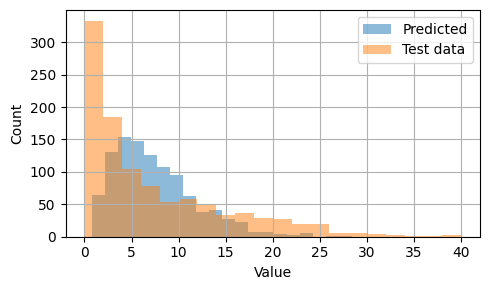

In [13]:
plt.figure(figsize=(5, 3))
plt.hist(y_mean_mc, bins=20, alpha=0.5, label='Predicted')
plt.hist(y_test,         bins=20, alpha=0.5, label='Test data')
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Count')    
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
def plot_residuals(y_true, y_pred, y_err):
    fig, ax = plt.subplots()
    ax.errorbar(
        y_true,
        y_true - y_pred,
        yerr=y_err,
        marker="o",
        linestyle="None",
        c="k",
        markersize=2.5,
        linewidth=0.5,
    )
    ax.axhline(0, c="k", linestyle="--")
    ax.set_xlabel("Actual data")
    ax.set_ylabel("Residuals: Actual - Predicted")
    plt.show()

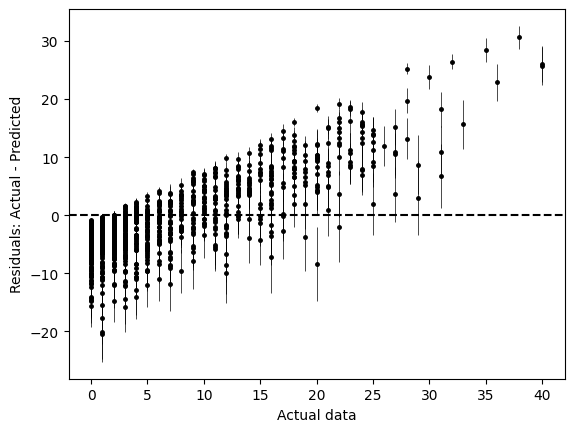

In [16]:
plot_residuals(y_test, y_mean_mc, y_std_mc)

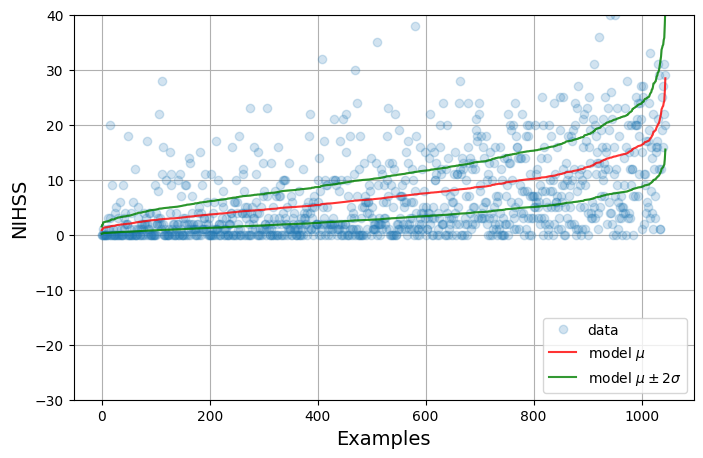

In [18]:
y_true = np.squeeze(y_test)
y_mean = np.squeeze(y_mean_mc)
y_sd = np.squeeze(y_std_mc)

fit_sd = np.poly1d(np.polyfit(x=y_mean, y=y_sd, deg=5))
y_sd_fit = fit_sd(y_mean)
order = np.argsort(y_mean)
y_lower = y_mean - 2*y_sd_fit
y_upper = y_mean + 2*y_sd_fit

plt.figure(figsize=(8, 5))
plt.plot(y_true[order], 'o', alpha=0.2, label='data')
plt.plot(y_mean[order], color='red', alpha=0.8, label='model $\mu$')
plt.plot(y_lower[order], color='green', alpha=0.15)
plt.plot(y_upper[order], color='green', alpha=0.15)
plt.plot(y_lower[order], color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
plt.plot(y_upper[order], color='green', alpha=0.8)
plt.xlabel('Examples', fontsize=14)
plt.ylabel('NIHSS', fontsize=14)
plt.ylim((-30, 40))
plt.legend(loc='lower right')
plt.grid()
plt.show()